In [1]:
import os
import pandas
import geopandas
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import time
g = 0
debug = 1

thisyear = 2018
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive']
inverse_color_cycle = ['green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'maroon', 'seagreen', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow']

print('ok')

ok


In [2]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

print('Reading block groups...')
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T

print('reading original congressional districts with urban/rural data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} original districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())

print('reading districts that have been matched so far...')
assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_7.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.loc[:, 'block_based_district'] = pandas.to_numeric(assembler_gdf['block_based_district'], errors='coerce')

print('backing up...')
cd_gdf_bk = cd_gdf
assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} district-marked block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




Reading block groups...
	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 147.6 seconds!
reading original congressional districts with urban/rural data...
Fixing at-large districts by setting district number to 1...
Read 435 original districts in 150.0 seconds.
reading districts that have been matched so far...
backing up...
Read 217,739 district-marked block groups in 151.1 seconds!


# Fixing districts for contiguity

In [ ]:
# print('Fixing Idaho...')
# assembler_gdf.loc['15000US160010105031', 'block_based_district'] = 2
# print('Fixing Nebraska...')
# assembler_gdf.loc['15000US311530106183', 'block_based_district'] = 1
# print('Fixing New Mexico...')
# assembler_gdf.loc['15000US350010047201', 'block_based_district'] = 3
# print('Fixing Arkansas...')
# assembler_gdf.loc[['15000US051011802002', '15000US051310101022'], 'block_based_district'] = 3
# assembler_gdf.loc[['15000US051299701002', '15000US050690025001'], 'block_based_district'] = 1
# print('Fixing Kansas...')
# assembler_gdf.loc['15000US201459703001', 'block_based_district'] = 1
# assembler_gdf.loc['15000US201211004001', 'block_based_district'] = 2
# print('Fixing Nevada...')
# assembler_gdf.loc['15000US320030050161', 'block_based_district'] = 4
# print('Fixing Utah...')
# assembler_gdf.loc['15000US490351139071', 'block_based_district'] = 2
# assembler_gdf.loc[['15000US490351101041', '15000US490351101042'], 'block_based_district'] = 3
# print('Fixing Connecticut...')
# assembler_gdf.loc[['15000US090053108041', '15000US090075412001'], 'block_based_district'] = 1
# assembler_gdf.loc[['15000US090093519002', '15000US090093516024', '15000US090093528002', '15000US090093514003', '15000US090093517002'], 'block_based_district'] = 3
# assembler_gdf.loc['15000US090093516022', 'block_based_district'] = 5
# print('Fixing Oregon...')
# assembler_gdf.loc[['15000US410050223012', '15000US410050223013'], 'block_based_district'] = 3
# print('Fixing Kentucky...')
# assembler_gdf.loc[['15000US212150801032', '15000US212150802003', '15000US212150801032', '15000US212150801032'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US212150801021', '15000US212150801022', '15000US212150802002'], 'block_based_district'] = 4
# print('Fixing Louisiana...')
# assembler_gdf.loc[['15000US220379515022', '15000US220379516004', '15000US220379515021', '15000US220330030002'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US220979618001'], 'block_based_district'] = 4  # was 3
# assembler_gdf.loc[['15000US221059540021'], 'block_based_district'] = 1  # was 5
# assembler_gdf.loc[['15000US220479529003'], 'block_based_district'] = 2 # was 6
# assembler_gdf.loc[['15000US220890621003'], 'block_based_district'] = 2  # was 6
# assembler_gdf.loc[['15000US220070501003'], 'block_based_district'] = 6 # was 2                   
# assembler_gdf.loc[['15000US220890622001', '15000US220050304021'], 'block_based_district'] = 6 #  was 2
# assembler_gdf.loc[['15000US220510248003'], 'block_based_district'] = 2  # was 1
# assembler_gdf.loc[['15000US220050303001', '15000US220050303002', '15000US220050306001', '15000US220050304022', '15000US220050304023'], 'block_based_district'] = 2  # was 6
# assembler_gdf.loc[['15000US220950701002'], 'block_based_district'] = 6 #  was 2
# assembler_gdf.loc[['15000US220950702001', '15000US220710144001', '15000US220710133021'], 'block_based_district'] = 2   # was 1
# assembler_gdf.loc[['15000US220510249002', '15000US220710129002'], 'block_based_district'] = 1 #  was 2
# print('Fixing Alabama...')
# assembler_gdf.loc[['15000US010730112071', '15000US010730112091'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US010730059033', '15000US010730142033', '15000US010730123051'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US011010010002'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US010259579022'], 'block_based_district'] = 1
#assembler_gdf.loc[['15000US010730111042'], 'block_based_district'] = 7
# print('Fixing Colorado...')
# assembler_gdf.loc[['15000US080140311002'], 'block_based_district'] = 2   #  was 2
# assembler_gdf.loc[['15000US080590605003'], 'block_based_district'] = 7   # was 7
# assembler_gdf.loc[['15000US080310120143'], 'block_based_district'] = 7    # was 1
# assembler_gdf.loc[['15000US080590120412'], 'block_based_district'] = 7    # was 1
# assembler_gdf.loc[['15000US080590120223'], 'block_based_district'] = 2   # was 1
# assembler_gdf.loc[['15000US080050071043'], 'block_based_district'] = 6   # was 4
# print('Fixing South Carolina...')
# assembler_gdf.loc[['15000US450750119003'], 'block_based_district'] = 6   #  was 2
# assembler_gdf.loc[['15000US450790114111'], 'block_based_district'] = 6   #  was 2
# assembler_gdf.loc[['15000US450790114121', '15000US450790027002', '15000US450790027003', '15000US450790026031', '15000US450790111013'], 'block_based_district'] = 2   #  was 6
# assembler_gdf.loc[['15000US450130003001', '15000US450130003002', '15000US450130005011', '15000US450130003003', '15000US450130002001'], 'block_based_district'] = 6   #  was 1
# assembler_gdf.loc[['15000US450190031073'], 'block_based_district'] = 6 # = 6
# assembler_gdf.loc[['15000US450150204041', '15000US450150206002'], 'block_based_district'] = 6 # was 1

# # print('Fixing Maryland...')
# # assembler_gdf.loc[['15000US240317001031'], 'block_based_district'] = 8   #  was 3
# # assembler_gdf.loc[['15000US240317001032'], 'block_based_district'] = 8   #  was 8
# # assembler_gdf.loc[['15000US240317002072'], 'block_based_district'] = 8   #  was 6
# # assembler_gdf.loc[['15000US240317013081'], 'block_based_district'] = 8   #  was 3
# # assembler_gdf.loc[['15000US240317015093', '15000US240317015051'], 'block_based_district'] = 8   #  was 3
# # assembler_gdf.loc[['15000US240037406031'], 'block_based_district'] = 4 # was 2
# # assembler_gdf.loc[['15000US240037406032'], 'block_based_district'] = 3 # was 2
# # assembler_gdf.loc[['15000US245102701012', '15000US245102603013'], 'block_based_district'] = 3 # was 2
# # assembler_gdf.loc[['15000US245102603011'], 'block_based_district'] = 3 # was 2
# # assembler_gdf.loc[['15000US245102708031', '15000US245102708032'], 'block_based_district'] = 3 # was 7

# print('Fixing Missouri...')
# assembler_gdf.loc[['15000US291833117212'], 'block_based_district'] = 2   #  was 3
# assembler_gdf.loc[['15000US291892131021'], 'block_based_district'] = 1   #  was 2
# assembler_gdf.loc[['15000US291892189002', '15000US291892193001'], 'block_based_district'] = 1   #  was 2

#print('Fixing Wisconsin...')
#assembler_gdf.loc[['15000US550170109003'], 'block_based_district'] = 7   #  was 3

#print('Fixing Arizona...')
# assembler_gdf.loc[['15000US040130822061'], 'block_based_district'] = 3 # was 1

# print('Fixing North Carolina...')
# assembler_gdf.loc[['15000US370630020272', '15000US370630020273'], 'block_based_district'] = 4 # was 1
# print('Fixed!')

# print('Fixing Ohio...')
# assembler_gdf.loc[['15000US391450023002', '15000US391450024004'], 'block_based_district'] = 6   #  was 2
# assembler_gdf.loc[['15000US390490063874', '15000US390490063714', '15000US390490063861'], 'block_based_district'] = 15   #  was 12
# assembler_gdf.loc[['15000US390490043002', '15000US390490082411', '15000US390490084001'], 'block_based_district'] = 3   #  was 15
# assembler_gdf.loc[['15000US391535202012', '15000US391535202021', '15000US391535202024'], 'block_based_district'] = 13   #  was 14
print("ok")

## OHIO

In [ ]:
#### this_state = 'OH'
this_state_number = 39
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'lower left'

# # WHOLE STATE
xlimits = (-85.05,-80.7)
ylimits = (38.2,42.4)

# # TOLEDO
# xlimits = (-83.71,-83.62)
# ylimits = (41.59,41.68)

# # CINC
# xlimits = (-84.7,-84.3)
# ylimits = (39,39.4)

# PORTSMOUTH
# xlimits = (-83.2,-82.8)
# ylimits = (38.6,39.1)

# COLUMBUS METRO
# xlimits = (-83.3,-82.6)
# ylimits = (39.74,40.2)

# COLUMBUS NW
# xlimits = (-83.14,-83.04)
# ylimits = (40.06,40.13)

# # COLUMBUS WEST LOBE
# xlimits = (-83.22,-83.03)
# ylimits = (39.86,40.03)

# # COLUMBUS WEST LOBE NE
# xlimits = (-83.096,-83.016)
# ylimits = (39.953,40.005)

# # COLUMBUS SOUTH LOBE
# xlimits = (-83.05,-82.87)
# ylimits = (39.78,39.93)

# # COLUMBUS SOUTH LOBE NEAR-INTERSECTION CLOSEUP
# xlimits = (-82.98,-82.96)
# ylimits = (39.87,39.885)

# # COLUMBUS NE
# xlimits = (-82.92,-82.77)
# ylimits = (39.95,40.1)

# NW SHORE
# xlimits = (-83.8,-81.9)
# ylimits = (41.1,41.9)

# NE SHORE INCL CLEVELAND
# xlimits = (-82.1,-81.43)
# ylimits = (41.16,41.7)

## NW OHIO
# xlimits = (-82.7,-80.9)
# ylimits = (40.4,41.5)

## MANSFIELD
# xlimits = (-82.63,-82.43)
# ylimits = (40.63,40.86)

## AKRON/CANTON METRO
# xlimits = (-81.72,-81.3)
# ylimits = (40.9,41.3)

## AKRON/CANTON NORTH-CENTRAL
xlimits = (-81.552,-81.448)
ylimits = (41.12,41.18)

# ## AKRON/CANTON NORTHWEST
# xlimits = (-81.63,-81.545)
# ylimits = (41.095,41.16)

# ## AKRON/CANTON DEAD CENTER
# xlimits = (-81.53,-81.46)
# ylimits = (41.045,41.105)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.01*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.05*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=13, ha='center'
#               )
    
plt.xticks(fontsize=2*basesize)
plt.yticks(fontsize=2*basesize)
    
# print('POPULATION IN EACH DISTRICT')
# for i in range(1, nDistricts+1):
#     print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)


In [ ]:

s = time.time()

this_state = 'OH'
this_state_number = 39
#this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

if (debug >= 1):
    print('reading area water shapefiles in {0:}...'.format(this_state))

water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

water_gdf = water_gdf.set_index('HYDROID')
e = time.time()
g = g + (e-s)
print('Read {0:,.0f} water areas in {1:,.0f} seconds!'.format(len(water_gdf), e-s))

## GEORGIA - NO CHANGES NEEDED

In [ ]:
this_state = 'GA'
this_state_number = 13
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'upper right'

# # WHOLE STATE
xlimits = (-85.5,-80.8)
ylimits = (30.5,35.3)

# # ATLANTA METRO
xlimits = (-85.3,-83.7)
ylimits = (33.3,34.5)


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

# for i in range(1, nDistricts+1):
#     cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
#          ax=ax, color='none', edgecolor='white', lw=0.25*basesize
#     )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=13, ha='center'
#               )
    
plt.xticks(fontsize=2*basesize)
plt.yticks(fontsize=2*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)


In [ ]:
s = time.time()

this_state = 'GA'
this_state_number = 13
#this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

if (debug >= 1):
    print('reading area water shapefiles in {0:}...'.format(this_state))

water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

water_gdf = water_gdf.set_index('HYDROID')
e = time.time()
g = g + (e-s)
print('Read {0:,.0f} water areas in {1:,.0f} seconds!'.format(len(water_gdf), e-s))

## MICHIGAN - NO CHANGES NEEDED

In [ ]:
this_state = 'MI'
this_state_number = 26
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'upper left'

# # WHOLE STATE
xlimits = (-91,-82)
ylimits = (41.7,48.3)

## LOWER PENINSULA EXCEPT DISTRICT 1
xlimits = (-87,-82.24)
ylimits = (41.7,44.6)

## GRAND RAPIDS-ISH
# xlimits = (-86.4,-85.2)
# ylimits = (42.6,43.3)

## SAGINAW
# xlimits = (-84.3,-83.8)
# ylimits = (43.15,43.65)

## DETROIT METRO
xlimits = (-84,-82.5)
ylimits = (41.5,43)

## 7 VS 9
# xlimits = (-83.35,-83.14)
# ylimits = (42.48,42.66)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

# for i in range(1, nDistricts+1):
#     cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
#          ax=ax, color='none', edgecolor='white', lw=0.25*basesize
#     )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=13, ha='center'
#               )
    
plt.xticks(fontsize=2*basesize)
plt.yticks(fontsize=2*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)


In [ ]:

s = time.time()

this_state = 'MI'
this_state_number = 26
#this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

if (debug >= 1):
    print('reading area water shapefiles in {0:}...'.format(this_state))

water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

water_gdf = water_gdf.set_index('HYDROID')
e = time.time()
g = g + (e-s)
print('Read {0:,.0f} water areas in {1:,.0f} seconds!'.format(len(water_gdf), e-s))

## NORTH CAROLINA

In [ ]:
this_state = 'NC'
this_state_number = 37
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'upper left'

# # WHOLE STATE
xlimits = (-84.8,-75.5)
ylimits = (33.5,36.6)

# # WEST
# xlimits = (-84.8,-79.5)
# ylimits = (34.6,36.6)

# # CHARLOTTE METRO
# xlimits = (-81.3,-80.4)
# ylimits = (34.9,35.7)

# N CENTRAL
# xlimits = (-80.5,-78.3)
# ylimits = (34.8,36.6)

# WEIRDNESS 146
# xlimits = (-78.95,-78.86)
# ylimits = (35.85,35.92)


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white', lw=0.25*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=13, ha='center'
#               )
    
plt.xticks(fontsize=2*basesize)
plt.yticks(fontsize=2*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)


In [ ]:
s = time.time()

this_state = 'NC'
this_state_number = 37
#this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

if (debug >= 1):
    print('reading area water shapefiles in {0:}...'.format(this_state))

water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

water_gdf = water_gdf.set_index('HYDROID')
e = time.time()
g = g + (e-s)
print('Read {0:,.0f} water areas in {1:,.0f} seconds!'.format(len(water_gdf), e-s))

## NEW JERSEY - NO CHANGES NEEDED

In [ ]:
this_state = 'NJ'
this_state_number = 34
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'center right'

# # WHOLE STATE
xlimits = (-75.6,-73.8)
ylimits = (38.6,41.45)

# # SOUTHEAST
# xlimits = (-75.6,-74.6)
# ylimits = (38.6,40.25)

# # CENTRAL
# xlimits = (-75,-73.9)
# ylimits = (40.0,40.7)

# # CENTRAL COAST
# xlimits = (-74.38,-73.95)
# ylimits = (40.15,40.47)

# # CENTRAL BARRIER ISLANDS
# xlimits = (-74.07,-73.95)
# ylimits = (40.19,40.39)

# NYC AREA
xlimits = (-74.58,-73.8)
ylimits = (40.33,41.2)



aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

# for i in range(1, nDistricts+1):
#     cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
#          ax=ax, color='none', edgecolor='white', lw=0.25*basesize
#     )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=9, ha='center'
#               )
    
plt.xticks(fontsize=1*basesize)
plt.yticks(fontsize=1*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)


In [ ]:
this_state = 'NJ'
this_state_number = 34

print('reading water shapefiles in {0:}...'.format(this_state))
water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
water_gdf = water_gdf.set_index('HYDROID')

print('got water!')

## VIRGINIA - NO CHANGES NEEDED!

In [ ]:
this_state = 'VA'
this_state_number = 51
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'upper left'

# # WHOLE STATE
xlimits = (-84.4,-75.5)
ylimits = (36.5,39.5)

# WEST
# xlimits = (-80.2,-78.4)
# ylimits = (36.5,39.1)

# 7 AND 10
# xlimits = (-78.6,-77.4)
# ylimits = (36.85,39.5)

# RICHMOND
# xlimits = (-78,-77.2)
# ylimits = (37.2,37.7)

# DC SUBURBS
# xlimits = (-78,-77)
# ylimits = (38.2,39.1)

# # 10 VS 11 WATER WEIRDNESS
# xlimits = (-77.34,-77.22)
# ylimits = (38.66,38.73)

# SOUTHEAST
xlimits = (-77.2,-75.7)
ylimits = (36.5,37.5)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
#ax.legend(handles=legend_list, fontsize=18, loc=legend_location)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white', lw=0.2*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=9, ha='center'
#               )
    
plt.xticks(fontsize=2*basesize)
plt.yticks(fontsize=2*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)


In [ ]:

this_state = 'VA'
this_state_number = 51

print('reading water shapefiles in {0:}...'.format(this_state))
water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
water_gdf = water_gdf.set_index('HYDROID')

print('got water!')

## WASHINGTON - NO CHANGES NEEDED

In [ ]:
this_state = 'WA'
this_state_number = 53
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'upper left'

# WHOLE STATE
xlimits = (-125.2,-116.7)
ylimits = (45.5,49.2)

# SEATTLE METRO
xlimits = (-123.5,-122)
ylimits = (46.5,49.2)

# SEATTLE CITY
xlimits = (-122.56,-121.3)
ylimits = (47.1,48)


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=18, loc=legend_location)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white', lw=0.2*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=9, ha='center'
#               )
    
plt.xticks(fontsize=2*basesize)
plt.yticks(fontsize=2*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)


In [ ]:
this_state = 'WA'
this_state_number = 53

print('reading water shapefiles in {0:}...'.format(this_state))
water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
water_gdf = water_gdf.set_index('HYDROID')

print('got water!')

## TENNESSEE - NO CHANGES NEEDED

In [ ]:
this_state = 'TN'
this_state_number = 47
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'lower right'

# WHOLE STATE
xlimits = (-90.5,-81.5)
ylimits = (34.5,37)

# EAST
# xlimits = (-85.6,-81.5)
# ylimits = (34.5,37)

# CENTER
# xlimits = (-87.6,-85.6)
# ylimits = (34.5,37)

# WEST
# xlimits = (-90.5,-87.6)
# ylimits = (34.5,37)

# MEMPHIS
# xlimits = (-90.4,-89.5)
# ylimits = (34.7,35.5)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=18, loc=legend_location)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white', lw=0.2*basesize
    )
    
#water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=9, ha='center'
#               )
    
plt.xticks(fontsize=2*basesize)
plt.yticks(fontsize=2*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)
# -87.6,-85.6
#

In [ ]:
this_state = 'TN'
this_state_number = 47

print('reading water shapefiles in {0:}...'.format(this_state))
water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
water_gdf = water_gdf.set_index('HYDROID')

print('got water!')

## MASSACHUSETTS - NO CHANGES NEEDED

In [ ]:
this_state = 'MA'
this_state_number = 25
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'lower left'

# WHOLE STATE
xlimits = (-73.8,-69.8)
ylimits = (40.8,42.9)

# WEST
xlimits = (-73.8,-71.1)
ylimits = (41.8,42.9)

# EAST
xlimits = (-71.6,-70.65)
ylimits = (40.8,42.9)

# BOSTON METRO
xlimits = (-71.6,-70.95)
ylimits = (41.64,42.52)

# BOSTON CITY
xlimits = (-71.2,-70.8)
ylimits = (42.09,42.42)


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=18, loc=legend_location)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white', lw=0.2*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=9, ha='center'
#               )
    
plt.xticks(fontsize=1*basesize)
plt.yticks(fontsize=1*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)


In [ ]:
this_state = 'MA'
this_state_number = 25

print('reading water shapefiles in {0:}...'.format(this_state))
water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
water_gdf = water_gdf.set_index('HYDROID')

print('got water!')

## INDIANA - NO CHANGES NEEDED

In [ ]:
#assembler_gdf.groupby('STUSAB').size()
# nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
# nDistricts 
assembler_gdf[assembler_gdf['STUSAB'] == 'IN'].groupby('block_based_district')['total_population'].sum()


In [ ]:
this_state = 'IN'
this_state_number = 18
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'lower left'

# WHOLE STATE
xlimits = (-88.3,-84.7)
ylimits = (37.7,41.9)




# aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
# print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=18, loc=legend_location)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white', lw=0.2*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=9, ha='center'
#               )
    
plt.xticks(fontsize=1*basesize)
plt.yticks(fontsize=1*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)



In [ ]:

this_state = 'IN'
this_state_number = 18

# try:
#     dummy = water_gdf.head(1).index.values[0]
# except NameError:
print('reading water shapefiles in {0:}...'.format(this_state))
water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
water_gdf = water_gdf.set_index('HYDROID')

print('got water!')

## ARIZONA

In [ ]:
#assembler_gdf.groupby('STUSAB').size()
# nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
# nDistricts 
assembler_gdf[assembler_gdf['STUSAB'] == 'AZ'].groupby('block_based_district')['total_population'].sum()


In [ ]:
this_state = 'AZ'
this_state_number = 4
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'lower left'

# WHOLE STATE
xlimits = (-115.1,-108.9)
ylimits = (31.2,37.2)

#  TUCSON METRO
# xlimits = (-111.3,-110.5)
# ylimits = (31.7,32.5)

# TUCSON CITY
# xlimits = (-111.07,-110.9)
# ylimits = (32.17,32.28)

# PHOENIX METRO
xlimits = (-112.8,-111.3)
ylimits = (33,34.2)

# PHOENIX WEIRDNESS
xlimits = (-112.28,-112.2)
ylimits = (33.33,33.43)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=18, loc=legend_location)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white', lw=0.2*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

b = []
for ix, thisrow in assembler_gdf[
    (assembler_gdf['STUSAB'] == this_state) 
    #& (assembler_gdf.index == '15000US240276051032') 
    & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
    & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
].iterrows():
    b.append(ix)
    annotator = ix[-6:]
    plt.annotate(annotator, 
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                 color='black', backgroundcolor='white', fontsize=9, ha='center'
              )
    
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

for x in b:    
    print(x)



In [ ]:
this_state = 'AZ'
this_state_number = 4
try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')

print('got water!')

## WISCONSIN

In [ ]:
#assembler_gdf.groupby('STUSAB').size()
# nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
# nDistricts 
assembler_gdf[assembler_gdf['STUSAB'] == 'WI'].groupby('block_based_district')['total_population'].sum()

In [ ]:
#### this_state = 'WI'
this_state_number = 55
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'lower left'

# WHOLE STATE
xlimits = (-93,-86.5)
ylimits = (42.4,47.2)

# 3 vs 7
# xlimits = (-91.5,-90.6)
# ylimits = (43.8,45.2)

# # EASTERN HALF OF STATE
# xlimits = (-89.5,-86.5)
# ylimits = (42.4,44.5)

# # 5 vs 6
# xlimits = (-88.7,-88.2)
# ylimits = (43.3,43.6)

# 1 vs 2
# xlimits = (-89.2,-88.7)
# ylimits = (42.4,43.2)

# MILWAUKEE METRO
# xlimits = (-88.6,-87.8)
# ylimits = (42.8,43.3)

# MILWAUKEE CITY
# xlimits = (-88.085,-87.82)
# ylimits = (42.86,43.21)


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)


fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=18, loc=legend_location)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.1*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=9, ha='center'
#               )
    
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)



In [ ]:

this_state = 'WI'
this_state_number = 55
try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')

print('got water!')

## MISSOURI

In [ ]:
this_state = 'MO'
this_state_number = 29
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'lower left'

# WHOLE STATE
xlimits = (-96.4,-88.8)
ylimits = (35.7,40.6)

# KC AREA
xlimits = (-94.7,-94.26)
ylimits = (38.88,39.3)

# KC AREA CLOSEUP
# xlimits = (-94.62,-94.46)
# ylimits = (39.15,39.25)

# 4 VS 6
# xlimits = (-92,-91.5)
# ylimits = (39,39.6)

# STL METRO
# xlimits = (-90.85,-90.05)
# ylimits = (38.15,39)

# # STL METRO NORTHWEST
# xlimits = (-90.7,-90.65)
# ylimits = (38.74,38.82)

#STL METRO NORTHEAST
# xlimits = (-90.56,-90.48)
# ylimits = (38.74,38.801)

#STL METRO FAR SOUTH
# xlimits = (-90.76,-90.42)
# ylimits = (38.24,38.41)


# STL CITY
# xlimits = (-90.5,-90.05)
# ylimits = (38.5,38.9)

# STL CITY SE
# xlimits = (-90.32,-90.23)
# ylimits = (38.5,38.56)

# STL CITY FAR S
# xlimits = (-90.385,-90.3)
# ylimits = (38.58,38.7)


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)


fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=18, loc=legend_location)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white', lw=0.25*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=9, ha='center'
#               )
    
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

# for x in b:    
#     print(x)


In [ ]:

this_state = 'MO'
this_state_number = 29
try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')

print('got water!')

## MINNESOTA

In [ ]:
this_state = 'MN'
this_state_number = 27
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'lower left'

# WHOLE STATE
xlimits = (-97.5,-89.4)
ylimits = (43.3,49.5)

# SOUTH CENTRAL
xlimits = (-95,-92)
ylimits = (44.1,46)

# MSP METRO
xlimits = (-93.6,-92.6)
ylimits = (44.7,45.3)


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)


fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=18, loc=legend_location)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.75*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=9, ha='center'
#               )
    
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()

# for x in b:
#     print(x)


In [ ]:
try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')

print('got water!')

## MARYLAND

In [ ]:
this_state = 'MD'
this_state_number = 24
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16
legend_location = 'lower left'


# print('Fixing Maryland...')
# assembler_gdf.loc[['15000US240317001031'], 'block_based_district'] = 8   #  was 3
# assembler_gdf.loc[['15000US240317001032'], 'block_based_district'] = 8   #  was 8
# assembler_gdf.loc[['15000US240317002072'], 'block_based_district'] = 8   #  was 6
# assembler_gdf.loc[['15000US240317013081'], 'block_based_district'] = 8   #  was 3
# assembler_gdf.loc[['15000US240317015093', '15000US240317015051'], 'block_based_district'] = 8   #  was 3
# assembler_gdf.loc[['15000US240037406031'], 'block_based_district'] = 4 # was 2
# assembler_gdf.loc[['15000US240037406032'], 'block_based_district'] = 3 # was 2
# assembler_gdf.loc[['15000US245102701012', '15000US245102603013'], 'block_based_district'] = 3 # was 2
# assembler_gdf.loc[['15000US245102603011'], 'block_based_district'] = 3 # was 2
# assembler_gdf.loc[['15000US245102708031', '15000US245102708032'], 'block_based_district'] = 3 # was 7

# WHOLE STATE
xlimits = (-79.7,-74.9)
ylimits = (37.8,39.8)

# 6 vs 8 (Frederick-Rockville area)
# xlimits = (-78,-77)
# ylimits = (38.8, 39.85)

# ROCKVILLE
# xlimits = (-77.3,-77)
# ylimits = (39.05,39.3)

# SSE ROCKVILLE
# xlimits = (-77.13,-77.07)
# ylimits = (39.05,39.09)

# N DC SUBURBS
# xlimits = (-77.25,-76.8)
# ylimits = (38.72,39.25)

# BETHESDA WEIRDNESS
# xlimits = (-77.02,-76.92)
# ylimits = (39.02,39.09)

# NE OF DC
# xlimits = (-77.1,-76.3)
# ylimits = (38.6,39.25)

# 2/3/4/5 OVERLAP WEIRDNESS
# xlimits = (-76.87,-76.63)
# ylimits = (38.8,39.17)

# NORTH-CENTRAL
# xlimits = (-77.4,-76)
# ylimits = (39.03,39.73)

# BALTIMORE METRO
# xlimits = (-76.7, -76.45)
# ylimits = (39.23, 39.46)

# NE BALTIMORE
# xlimits = (-76.6,-76.535)
# ylimits = (39.315,39.38)

# DISTRICT 2 BULLSHIT
# xlimits = (-76.95,-76.2)
# ylimits = (38.85,39.7)

# DISTRICT 2 BULLSHIT NORTH
# xlimits = (-76.66,-76.48)
# ylimits = (39.33,39.51)

# DISTRICT 2 BULLSHIT SOUTHWEST
# xlimits = (-76.89,-76.73)
# ylimits = (39.32,39.42)

# DISTRICT 1 BULLSHIT
# xlimits = (-76.7,-75.9)
# ylimits = (39.05,39.77)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)


fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
ax.legend(handles=legend_list, fontsize=18, loc=legend_location)

# for i in range(1, nDistricts+1):
#     cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
#          ax=ax, color='none', edgecolor='white', lw=0.2*basesize
#     )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf.index == '15000US240276051032') 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=9, ha='center'
#               )
    
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()

# for x in b:
#     print(x)


In [ ]:
try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')

print('got water!')

In [ ]:
print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
#for this_state in ['NE', 'NM', 'AR', 'KS', 'MS', 'NV', 'UT', 'CT', 'OK', 'OR', 'KY', 'LA']:

## SOUTH CAROLINA

1.4054054054054064
POPULATION IN EACH DISTRICT
District 1: 750,929
District 2: 711,634
District 3: 693,429
District 4: 711,928
District 5: 702,526
District 6: 676,149
District 7: 709,330


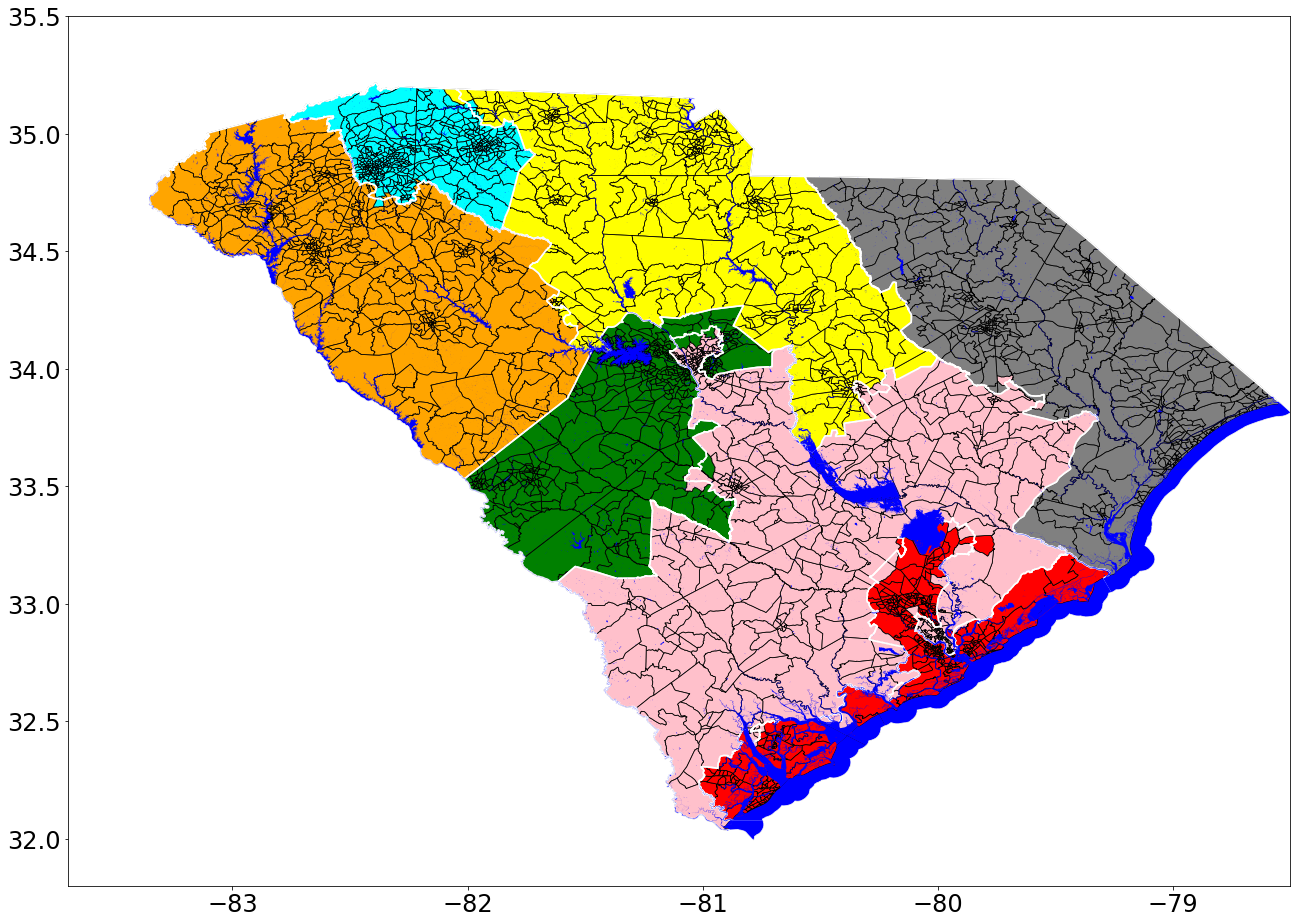

In [6]:
this_state = 'SC'
this_state_number = 45
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 16

# assembler_gdf.loc[['15000US450750119003'], 'block_based_district'] = 6   #  was 2
# assembler_gdf.loc[['15000US450790114111'], 'block_based_district'] = 6   #  was 2
# assembler_gdf.loc[['15000US450790114121', '15000US450790027002', '15000US450790027003', '15000US450790026031', '15000US450790111013'], 'block_based_district'] = 2   #  was 6


# assembler_gdf.loc[['15000US450130003001', '15000US450130003002', '15000US450130005011', '15000US450130003003', '15000US450130002001'], 'block_based_district'] = 6   #  was 1


# assembler_gdf.loc[['15000US450190031073'], 'block_based_district'] = 6 # = 6

# assembler_gdf.loc[['15000US450150204041', '15000US450150206002'], 'block_based_district'] = 6 # was 1

# WHOLE STATE
xlimits = (-83.7,-78.5)
ylimits = (31.8,35.5)

# NW
# xlimits = (-83.7,-81.4)
# ylimits = (33.2,35.5)

# COLUMBIA METRO
# xlimits = (-81.25,-80.5)
# ylimits = (33.2,34.35)

# COLUMBIA FAR SOUTH
# xlimits = (-81.1,-80.9)
# ylimits = (33.4,33.63)

# COLUMBIA CITY
# xlimits = (-81.18,-80.82)
# ylimits = (33.9,34.22)


# COLUMBIA CITY NE
# xlimits = (-80.98,-80.9)
# ylimits = (34.09,34.20)

# COLUMBIA CITY E
# xlimits = (-80.96,-80.89)
# ylimits = (34.04,34.14)

# COLUMBIA DOWNTOWN
# xlimits = (-81.035,-80.975)
# ylimits = (33.963,34.05)

# SOUTH OF COLUMBIA
# xlimits = (-81.5,-80.5)
# ylimits = (33,34)

# FAR SOUTH
# xlimits = (-81.2,-80.1)
# ylimits = (31.8,32.7)

# SOUTH WEIRDNESS
# xlimits = (-80.85,-80.71)
# ylimits = (32.37,32.53)

# SOUTH WEIRDNESS II
# xlimits = (-80.66,-80.3)
# ylimits = (32.38,32.73)

# N OF CHARLESTON
# xlimits = (-80.4,-79.7)
# ylimits = (32.4,33.4)


# SW CHARLSTON WEIRDNESS
# xlimits = (-80.25,-80.12)
# ylimits = (32.52,32.73)

# NNE OF CHARLSTON WEIRDNESS
# xlimits = (-80.15,-80.06)
# ylimits = (32.8,33.14)

# SMALL DUE N OF CHARLSTON WEIRDNESS
# xlimits = (-80.06,-79.96)
# ylimits  = (32.88,32.96)

# N OF CHARLESTON BIG-AREA WEIRDNESS
# xlimits = (-80.1,-79.7)
# ylimits = (33.16,33.4)

# NE OF STATE
# xlimits = (-79.8,-79.5)
# ylimits = (33.75,34)


try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)


fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white', lw=0.1*basesize
    )
    
water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
# #    (assembler_gdf.index == '15000US450130005012')
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=9, ha='center'
#               )
    
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()

# for x in b:
#     print(x)


## COLORADO FIXED TO BE CONTIGUOUS (7 CHANGES)

In [ ]:
this_state = 'CO'
this_state_number = 8
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 8

# assembler_gdf.loc[['15000US080140311002'], 'block_based_district'] = 2   #  was 2
# assembler_gdf.loc[['15000US080590605003'], 'block_based_district'] = 7   # was 7
# assembler_gdf.loc[['15000US080310120143'], 'block_based_district'] = 7    # was 1
# assembler_gdf.loc[['15000US080590120412'], 'block_based_district'] = 7    # was 1
# assembler_gdf.loc[['15000US080590120223'], 'block_based_district'] = 2   # was 1
# assembler_gdf.loc[['15000US080050071043'], 'block_based_district'] = 6   # was 4

# # WHOLE STATE
xlimits = (-109.2,-101.8)
ylimits = (36.8,41.2)

# # CENTER
# xlimits = (-106.9,-104.1)
# ylimits = (39,40.2)

# 2 VS 3
# xlimits = (-106.65,-106.42)
# ylimits = (39.4,39.8)

# DENVER METRO
# xlimits = (-105.45,-104.3)
# ylimits = (39.48,40.08)

# NORTH DENVER
# xlimits = (-105.3,-104.94)
# ylimits = (39.85,40.08)

# SOUTH DENVER
# xlimits = (-105.17,-104.97)
# ylimits = (39.57,39.65)

# SOUTH DENVER NARROWER
# xlimits = (-105.138,-105.098)
# ylimits = (39.61,39.64)

# EXURBAN SE DENVER
# xlimits = (-105.1, -104.6)
# ylimits = (39.45,39.78)

# EXURBAN SSE DENVER CLOSEUP
# xlimits = (-105.08,-104.87)
# ylimits = (39.48,39.54)

# EXURBAN ESE DENVER CLOSEUP
# xlimits = (-104.75,-104.6)
# ylimits = (39.5,39.75)

try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)


fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', linewidth=0.05*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )
    
#water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
# #    (assembler_gdf.index == '15000US080590120223')
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#               )
    
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()

# for x in b:
#     print(x)

## ALABAMA FIXED TO BE CONTIGUOUS (7 CHANGES)

In [ ]:
this_state = 'AL'
this_state_number = 1
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 8

# assembler_gdf.loc[['15000US010730112071', '15000US010730112091'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US010730059033', '15000US010730142033', '15000US010730123051'], 'block_based_district'] = 7

# assembler_gdf.loc[['15000US011010010002'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US010259579022'], 'block_based_district'] = 1

#assembler_gdf.loc[['15000US010730111042'], 'block_based_district'] = 7
# WHOLE STATE
# xlimits = (-89,-84)
# ylimits = (30,35.5)

# NORTH OF BIRMINGHAM
# xlimits = (-88.35,-85.05)
# ylimits = (33.7,35.3)

# DUE EAST OF BIRMINGHAM
# xlimits = (-86.5,-85.21)
# ylimits = (32.9,33.7)

# BIRMINGHAM METRO
# xlimits = (-87.05,-86.6)
# ylimits = (33.23,33.72)

# WEIRD 6 VS 7
# xlimits = (-86.69,-86.63)
# ylimits = (33.6,33.68)

# NE BIRMINGHAM
# xlimits = (-86.74,-86.6)
# ylimits = (33.55,33.69)

# N BIRMINGHAM
# xlimits = (-86.96,-86.75)
# ylimits = (33.55,33.63)

# W BIRMINGHAM
# xlimits = (-87.0,-86.86)
# ylimits = (33.56,33.6)

# TUSCALOOSA
# xlimits = (-87.73,-87.23)
# ylimits = (33.19,33.36)

# DUE WEST OF TUSCALOOSA
# xlimits = (-88.35,-87.6)
# ylimits = (32.9,33.7)

# SOUTH EXCEPT MOBILE
# xlimits = (-88.5,-84.6)
# ylimits = (30.9,33.3)

# MONTGOMERY
# xlimits = (-86.375,-86.1)
# ylimits = (32.15,32.45)

# # EAST SIDE OF MONTGOMERY
# xlimits = (-86.28,-86.1)
# ylimits = (32.15,32.45)

# # WEST SIDE OF MONTGOMERY
# xlimits = (-86.375,-86.23)
# ylimits = (32.33,32.38)

# JACKSON / GROVE HILL
# xlimits = (-88.2,-87.3)
# ylimits = (31.15,31.9)

# GROVE HILL CLOSE-UP
# xlimits = (-87.97,-87.81)
# ylimits = (31.48,31.6)

# MOBILE
xlimits = (-88.7,-87.2)
ylimits = (30.05,31.5)

try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )
    
#water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
# #    (assembler_gdf.index != '15000US011010011003')
#      (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
    
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()

# for x in b:
#     print(x)


## LOUISIANA FIXED TO BE CONTIGUOUS (23 CHANGES)

In [ ]:
this_state = 'LA'
this_state_number = 22
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())


# BATON ROUGE
xlimits = (-91.5,-90.8)
ylimits = (30,31)

# BATON ROUGE WEIRDNESS
# xlimits = (-91,-90.8)
# ylimits = (30.16,30.26)

#xlimits = (-91.08,-90.75)
#ylimits = (30.06,30.4)



# # WEST/CENTER LAKE PONTCHARTRAIN
# xlimits = (-90.7,-90.1)
# ylimits = (29.7,30.5)

# # SOUTH LAKE PONTCHARTRAIN
# xlimits = (-90.4,-89.6)
# ylimits = (29.4,30.4)


#LAKE PONTCHARTRAIN WEIRDNESS WEST
# xlimits = (-90.54,-90.44)
# ylimits = (30.03,30.14)

#LAKE PONTCHARTRAIN WEIRDNESS CENTER
# xlimits = (-90.44,-90.28)
# ylimits = (29.92,30.01)

# # #LAKE PONTCHARTRAIN WEIRDNESS SOUTH
# xlimits = (-90.18,-90.08)
# ylimits = (29.89,29.986)

# ##LAKE PONTCHARTRAIN WEIRDNESS SOUTH II
# xlimits = (-90.1,-90)
# ylimits = (30,30.1)



# assembler_gdf.loc[['15000US220379515022', '15000US220379516004', '15000US220379515021', '15000US220330030002'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US220979618001'], 'block_based_district'] = 4  # was 3
# assembler_gdf.loc[['15000US221059540021'], 'block_based_district'] = 1  # was 5
# assembler_gdf.loc[['15000US220479529003'], 'block_based_district'] = 2 # was 6
# assembler_gdf.loc[['15000US220890621003'], 'block_based_district'] = 2  # was 6
# assembler_gdf.loc[['15000US220070501003'], 'block_based_district'] = 6 # was 2                   
# assembler_gdf.loc[['15000US220890622001', '15000US220050304021'], 'block_based_district'] = 6 #  was 2
# assembler_gdf.loc[['15000US220510248003'], 'block_based_district'] = 2  # was 1
# assembler_gdf.loc[['15000US220050303001', '15000US220050303002', '15000US220050306001', '15000US220050304022', '15000US220050304023'], 'block_based_district'] = 2  # was 6
# assembler_gdf.loc[['15000US220950701002'], 'block_based_district'] = 6 #  was 2
# assembler_gdf.loc[['15000US220950702001', '15000US220710144001', '15000US220710133021'], 'block_based_district'] = 2   # was 1
# assembler_gdf.loc[['15000US220510249002', '15000US220710129002'], 'block_based_district'] = 1 #  was 2


try:
    dummy = water_gdf.head(1).index.values[0]
except NameError:
    print('reading water shapefiles in {0:}...'.format(this_state))
    water_gdf = geopandas.GeoDataFrame()
    water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(water_file_list)):
        if (debug >= 1):
            if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
                print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
        water_gdf_i = geopandas.read_file(water_file_list[i])
        #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)
    water_gdf = water_gdf.set_index('HYDROID')



aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 16

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.01*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )
    
#water_gdf.plot(ax=ax, color='blue')

# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf.index == '15000US220050304021')
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
    
# plt.xticks(fontsize=1.5*basesize)
# plt.yticks(fontsize=1.5*basesize)


    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


# plt.xlim(xlimits)
# plt.ylim(ylimits)

plt.show()

# for x in b:
#     print(x)
# assembler_gdf.groupby('block_based_district').size()
#assembler_gdf[assembler_gdf['block_based_district'] == -1]


## KENTUCKY FIXED TO BE CONTIGUOUS (7 CHANGES)

In [ ]:
this_state = 'KY'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc[['15000US212150801032', '15000US212150802003', '15000US212150801032', '15000US212150801032'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US212150801021', '15000US212150801022', '15000US212150802002'], 'block_based_district'] = 4


# MISTAKEN DISTRICT 1
xlimits = (-85.6,-85.1)
ylimits = (37.93,38.18)

#     
#     


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.025*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     #(assembler_gdf.index != '15000US410050223013')
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )

# plt.xlim(xlimits)
# plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

# for x in b:
#     print(x)


## OREGON FIXED TO BE CONTIGUOUS (2 CHANGES)

In [ ]:
this_state = 'OR'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

#assembler_gdf.loc[['15000US410050223012', '15000US410050223013'], 'block_based_district'] = 3



# # # # # # NORTHWEST
# xlimits = (-124.5,-121.7)
# ylimits = (44,46.5)

# # # # # # METRO PORTLAND
# xlimits = (-122.8,-121.4)
# ylimits = (45,45.7)

# # # # # # SOUTH SIDE OF PORTLAND
# xlimits = (-122.61,-122.48)
# ylimits = (45.31,45.43)

# xlimits = (-122.615,-122.52)
# ylimits = (45.36,45.41)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.025*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     #(assembler_gdf.index != '15000US410050223013')
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )

# plt.xlim(xlimits)
# plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

# for x in b:
#     print(x)
    
    #   5


### OKLAHOMA is contiguous

In [ ]:
this_state = 'OK'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# # # # # NORTH-CENTRAL
# xlimits = (-98,-95)
# ylimits = (34.5,37.2)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', linewidth=0.025*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )

# plt.xlim(xlimits)
# plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## CONNECTICUT FIXED TO BE CONTIGUOUS (8 CHANGES)

In [ ]:
this_state = 'CT'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc[['15000US090053108041', '15000US090075412001'], 'block_based_district'] = 1
# assembler_gdf.loc[['15000US090093519002', '15000US090093516024', '15000US090093528002', '15000US090093514003', '15000US090093517002'], 'block_based_district'] = 3
# assembler_gdf.loc['15000US090093516022', 'block_based_district'] = 5

# # # # NORTH
# xlimits = (-73.25,-72.5)
# ylimits = (41.4,42.2)

# # # # 1 vs 5
# xlimits = (-73.25,-73.1)
# ylimits = (41.78,41.84)

# # # # 3 vs 4 vs 5
# xlimits = (-73.09,-72.99)
# ylimits = (41.505,41.565)

# 1 vs 3
# xlimits = (-72.71,-72.643)
# ylimits = (41.55,41.61)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', linewidth=0.025*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )

# plt.xlim(xlimits)
# plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
    
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## UTAH FIXED TO BE CONTIGUOUS (3 CHANGES)

In [ ]:
this_state = 'UT'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc['15000US490351139071', 'block_based_district'] = 2
# assembler_gdf.loc[['15000US490351101041', '15000US490351101042'], 'block_based_district'] = 3



# # # # SALT LAKE CITY
# xlimits = (-112.5,-111)
# ylimits = (39.2, 41)

# # # # # NORTH SALT LAKE CITY
# xlimits = (-112.3,-111.5)
# ylimits = (40.55,40.75)

# # # # # NORTHEAST SALT LAKE CITY
# xlimits = (-111.83,-111.75)
# ylimits = (40.62,40.68)


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow', linewidth=0.025*basesize
    )

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.25*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# for x in b:
#     print(x)

# plt.xlim(xlimits)
# plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## NEVADA FIXED TO BE CONTIGUOUS (1 CHANGE)

In [ ]:
this_state = 'NV'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

#assembler_gdf.loc['15000US320030050161', 'block_based_district'] = 4

# # # WHOLE STATE
xlimits = (-120.2, -113.8)
ylimits = (34.8,42.1)

# 1 vs 3 vs 4
# xlimits = (-116,-114.6)
# ylimits = (35.9, 36.5)

# # LAS VEGAS
# xlimits = (-115.3,-115)
# ylimits = (36,36.25)

# # EAST LAS VEGAS
# xlimits = (-115.05,-114.98)
# ylimits = (36.04,36.14)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow', linewidth=0.025*basesize
    )
#water_gdf.plot(ax=ax, color='blue')

#assembler_gdf[assembler_gdf.index == '15000US051011802002'].plot(ax=ax, color='none', edgecolor='white', lw=10)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.3*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     assembler_gdf.index == '15000US320030050161'
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# for x in b:
#     print(x)

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



### MISSISSIPPI is contiguous

In [ ]:
this_state = 'MS'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc['15000US201459703001', 'block_based_district'] = 4
# assembler_gdf.loc['15000US201211004001', 'block_based_district'] = 2
## #assembler_gdf.loc['15000US201211001001', 'block_based_district'] = 2


# # # WHOLE STATE
xlimits = (-91.7,-87.9)
ylimits = (29.9,35.3)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow', linewidth=0.025*basesize
    )
#water_gdf.plot(ax=ax, color='blue')

#assembler_gdf[assembler_gdf.index == '15000US051011802002'].plot(ax=ax, color='none', edgecolor='white', lw=10)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.3*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# for x in b:
#     print(x)

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## KANSAS FIXED TO BE CONTIGUOUS (2 CHANGES)

In [ ]:
this_state = 'KS'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc['15000US201459703001', 'block_based_district'] = 4
# assembler_gdf.loc['15000US201211004001', 'block_based_district'] = 2
## #assembler_gdf.loc['15000US201211001001', 'block_based_district'] = 2


# # WHOLE STATE
xlimits = (-102.5, -94.5)
ylimits = (36.8,40.2)

# MIS-DONE DISTRICT 2 IN THE MIDDLE
# xlimits = (-99.6,-99.1)
# ylimits = (37.7,38.5)

# 2 vs. 3
# xlimits = (-95.1, -94.5)
# ylimits = (38.2,38.76)

# 2 vs. 3 SOUTH
# xlimits = (-94.75, -94.55)
# ylimits = (38.3,38.65)


aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow', linewidth=0.025*basesize
    )
#water_gdf.plot(ax=ax, color='blue')

#assembler_gdf[assembler_gdf.index == '15000US051011802002'].plot(ax=ax, color='none', edgecolor='white', lw=10)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.3*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# for x in b:
#     print(x)

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## ARKANSAS DISTRICTS FIXED TO BE CONTIGUOUS (2 changes)

In [ ]:
this_state = 'AR'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc[['15000US051011802002', '15000US051310101022'], 'block_based_district'] = 3
# assembler_gdf.loc[['15000US051299701002', '15000US050690025001'], 'block_based_district'] = 1
## assembler_gdf.loc[['15000US051310013021','15000US050330204012','15000US050330204013', '15000US050330206001', '15000US050330206002', '15000US050330206003', '15000US050330206004'], 'block_based_district'] = 4

# # WHOLE STATE
xlimits = (-94.7,-89.5)
ylimits = (32.8,36.7)

# # NW ARK
# xlimits = (-94.7,-92.7)
# ylimits = (35.5,36.7)

# WEIRDNESS
# xlimits = (-93.4,-92.6)
# ylimits = (35.5,36.2)

# WEIRDNESS
# xlimits = (-93.5,-92.8)
# ylimits = (34.9,35.3)

# WEIRDNESS
# xlimits = (-92.2,-91.6)
# ylimits = (34,34.6)

# TRANSFER FROM 3 TO 4 FOR POPULATION EVENAGE?
# xlimits = (-94.7,-93.6)
# ylimits = (34.9,35.8)

# xlimits = (-94.33,-94)
# ylimits = (35.1,35.6)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow', linewidth=0.025*basesize
    )
#water_gdf.plot(ax=ax, color='blue')

#assembler_gdf[assembler_gdf.index == '15000US051011802002'].plot(ax=ax, color='none', edgecolor='white', lw=10)

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.3*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# for x in b:
#     print(x)

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=1.5*basesize)
plt.yticks(fontsize=1.5*basesize)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))



## NEW MEXICO DISTRICTS FIXED TO BE CONTIGUOUS (3 changes)

In [ ]:
this_state = 'NM'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# assembler_gdf.loc['15000US350010047201', 'block_based_district'] = 1
# assembler_gdf.loc['15000US350010047461', 'block_based_district'] = 3
# assembler_gdf.loc['15000US350619703014', 'block_based_district'] = 1



# # WHOLE STATE
xlimits = (-109.2,-102.9)
ylimits = (31.5,37.3)

# # 2 vs 3 WEST
# xlimits = (-109.2,-107.2)
# ylimits = (34.5,35.5)

# # 2 vs 3 EAST
# xlimits = (-105.4,-102.9)
# ylimits = (34,35.3)

# # 2 vs 3 EAST: PORTALES?
# xlimits = (-103.36,-103.3)
# ylimits = (34.15,34.19)

# # 1 vs all
# xlimits = (-107.5,-105)
# ylimits = (34,35.8)

# 1 closeup NW  - changed 2 block groups
# xlimits = (-106.77,-106.65)
# ylimits = (35.175,35.225)

# 1 closeup S
# xlimits = (-106.75,-106.4)
# ylimits = (34.71,34.82)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', linewidth=0.1*basesize
    )
#water_gdf.plot(ax=ax, color='blue')

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', lw=0.5*basesize
    )


# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
# #     annotator = 'Changed block group {0:}'.format(ix)
# #     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
# #     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=18, ha='center'
#                )

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1, nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

print('\n')

# for x in b:
#     print(x)

## NEBRASKA DISTRICTS FIXED TO BE CONTIGUOUS (1 change)

In [ ]:
this_state = 'NE'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

#assembler_gdf.loc['15000US311530106183', 'block_based_district'] = 2



# # WHOLE STATE
xlimits = (-104.2,-95.5)
ylimits = (39.8,43.2)

# # # 1 vs 3
xlimits = (-98,-95.5)
ylimits = (40.3,42.5)

# # 1 vs 2
xlimits = (-96.5,-95.7)
ylimits = (40.9,41.5)

# # AREA TO POSSIBLY FIX?
xlimits = (-96.025,-95.95)
ylimits = (41.1,41.2)

# # # # SLIGHT ZOOMOUT FROM AREA TO POSSIBLY FIX
# xlimits = (-96.1,-95.8)
# ylimits = (41,41.3)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1)#,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', linewidth=0.5
    )
#water_gdf.plot(ax=ax, color='blue')

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='purple', linewidth=2
    )

#cd_gdf[cd_gdf['CD116FP'] == 1].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)

c = []
for ix, thisrow in assembler_gdf[
    assembler_gdf.index == '15000US311530106183'
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
].iterrows():
    c.append(ix)
    annotator = ix #ix[-6:]
    annotator = 'Changed block group {0:}'.format(ix)
    annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
    annotator += '\nFROM CD 2 TO CD 1'

    
    plt.annotate(annotator, 
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                 color='black', backgroundcolor='white', fontsize=9, ha='center'
               )

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in range(1,nDistricts+1):
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


# for x in c:
#     print(x)

### MAINE DISTRICT BOUNDARIES ARE CONTIGUOUS

In [ ]:
this_state = 'ME'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# # WHOLE STATE
xlimits = [-71.3, -68.4]
ylimits = [43.6, 44.6]

# # AREA TO BE FIXED
# xlimits = [-116.4,-115.7]
# ylimits = [43.1,43.75]

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white'
    )
#water_gdf.plot(ax=ax, color='blue')

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white'
    )

#cd_gdf[cd_gdf['CD116FP'] == 1].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)

# #b = []
# for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
#     (assembler_gdf.index == '15000US160010105031')
# ].iterrows():
# #    b.append(ix)
#     annotator = 'Changed block group {0:}'.format(ix)
#     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
#     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=12, ha='center'
#                )

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in [1,2]:
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


### NEW HAMPSHIRE DISTRICT BOUNDARIES ARE CONTIGUOUS

In [ ]:
this_state = 'NH'
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())

# # WHOLE STATE
xlimits = [-71.8, -70.5]
ylimits = [42.6, 44.3]

# # AREA TO BE FIXED
# xlimits = [-116.4,-115.7]
# ylimits = [43.1,43.75]

#aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
#print(aspect_ratio)
#basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white'
    )
#water_gdf.plot(ax=ax, color='blue')

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color='none', edgecolor='white'
    )

#cd_gdf[cd_gdf['CD116FP'] == 1].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)

# #b = []
# for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
#     (assembler_gdf.index == '15000US160010105031')
# ].iterrows():
# #    b.append(ix)
#     annotator = 'Changed block group {0:}'.format(ix)
#     annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
#     annotator += '\nFROM CD 1 TO CD 2'
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=12, ha='center'
#                )

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.show()

# for x in b:
#     print(x)
print('POPULATION IN EACH DISTRICT')
for i in [1,2]:
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


## IDAHO DISTRICTS FIXED TO BE CONTIGUOUS (1 change)

In [ ]:
this_state = 'ID'

assembler_gdf.loc['15000US160010105031', 'block_based_district'] = 2

# WHOLE STATE
xlimits = [-116.4,-114]
ylimits = [41.9,46.1]

# AREA TO BE FIXED
# xlimits = [-116.4,-115.7]
# ylimits = [43.1,43.75]

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
#print(aspect_ratio)
basesize = 8

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

for i in range(1, int(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)]['block_based_district'].max()+1)):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow'
    )
#water_gdf.plot(ax=ax, color='blue')

cd_gdf[cd_gdf['CD116FP'] == 1].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)

#b = []
for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
    (assembler_gdf.index == '15000US160010105031')
].iterrows():
#    b.append(ix)
    annotator = 'Changed block group {0:}'.format(ix)
    annotator += '\n(population {0:,.0f})'.format((thisrow['total_population']))
    annotator += '\nFROM CD 1 TO CD 2'
    plt.annotate(annotator, 
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                 color='black', backgroundcolor='white', fontsize=12, ha='center'
               )

plt.xlim(xlimits)
plt.ylim(ylimits)

#plt.title('Changed block group {0:} (pop {1:,.0f} from CD 1 to CD 2)'.format(ix))
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.show()

# for x in b:
#     print(x)
print('NEW POPULATION IN EACH DISTRICT')
for i in [1,2]:
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


### HAWAII DISTRICT BOUNDARIES ARE CONTIGUOUS

In [ ]:
this_state = 'HI'

xlimits = [-158.4,-157.55]
ylimits = [21.19,21.78]

fig, ax = plt.subplots(1,1)
# # WESTERN SECTION OF BORDER IS GOOD
# xlimits = [-158.15,-158.05]
# ylimits = [21.28,21.4]

# CENTER SECTION OF BORDER IS GOOD
# xlimits = [-158.05,-157.87]
# ylimits = [21.38,21.52]

# EASTERN SECTION OF BORDER IS GOOD
# xlimits = [-157.87, -157.64]
# ylimits = [21.22, 21.44]

for i in range(1, int(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)]['block_based_district'].max()+1)):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='yellow'
    )
water_gdf.plot(ax=ax, color='blue')

plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()

print('POPULATION IN EACH DISTRICT')
for i in [1,2]:
    print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))


In [ ]:
s = time.time()

this_state = 'HI'
this_state_number = 15
#this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

if (debug >= 1):
    print('reading water shapefiles in {0:}...'.format(this_state))

water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

water_gdf = water_gdf.set_index('HYDROID')
e = time.time()
g = g + (e-s)

if (debug >= 1):
    #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
    print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

In [ ]:
this_state = 'MD'
this_state_number = 24
nDistricts = int(cd_gdf[(cd_gdf['STUSAB'] == this_state)]['CD116FP'].max())
basesize = 14
legend_location = 'upper left'


# NE BALTIMORE
xlimits = (-76.59,-76.555)
ylimits = (39.31,39.34)

aspect_ratio = ((xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0]))
#print(aspect_ratio)


fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))
legend_list = []

for i in [2,3,7]:# range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(
         ax=ax, color=district_color_cycle[i-1], edgecolor='white', lw=0.5*basesize
    )
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
    

for i in range(1, nDistricts+1):
    assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].plot(
         #ax=ax, color=district_color_cycle[i-1], edgecolor='black', linewidth=0.05*basesize
         ax=ax, color='none', edgecolor='black', linewidth=0.05*basesize
    )
    #legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))



water_gdf.plot(ax=ax, color='blue')

b = []
for ix, thisrow in assembler_gdf[
    (assembler_gdf['STUSAB'] == this_state) 
    #& (assembler_gdf.index == '15000US240276051032') 
    & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
    & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
].iterrows():
    b.append(ix)
    annotator = ix[-6:]
    plt.annotate(annotator, 
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                 color='black', backgroundcolor='white', fontsize=13, ha='center'
              )
ax.legend(handles=legend_list, fontsize=18, loc=legend_location)
plt.xticks(fontsize=1*basesize)
plt.yticks(fontsize=1*basesize)
    
# print('POPULATION IN EACH DISTRICT')
# for i in range(1, nDistricts+1):
#     print('District {0:.0f}: {1:,.0f}'.format(i, assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()))

plt.xlim(xlimits)
plt.ylim(ylimits)
plt.savefig('maryland-gerrymandering-mess.jpg', fmt='jpt')
print('ok')
plt.show()

# for x in b:
#     print(x)
